In [1]:
import pandas, numpy, seaborn

In [2]:
import scipy, scipy.stats
import sklearn, sklearn.decomposition, sklearn.preprocessing

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(8, 4)})

In [4]:
import pyensembl
annotation = pyensembl.EnsemblRelease(86) # better matching than version 100
annotation

EnsemblRelease(release=86, species='homo_sapiens')

In [5]:
import ensembl_rest
# ensembl_rest.lookup(id='ENSG00000139618')['description']

# 0. user-defined variables

In [6]:
expression_data_input_file = '/Users/adrian/gd15/hi/research/osteo/results/tpm/DESeq2_TPM_values.tsv'
metadata_file = '/Users/adrian/gd15/hi/research/osteo/metadata/MSC_Sample list.csv'
DEGs_input_file = '/Users/adrian/gd15/hi/research/osteo/results/DETs_filtered/entire_DEG_set.txt'
dorothea_database_file = '/Users/adrian/gd15/hi/research/osteo/data/dorothea/database.txt'
recon_file = '/Users/adrian/gd15/hi/research/osteo/data/recon3d_20210624/database.tsv'
volcano_info_file = '/Users/adrian/gd15/hi/research/osteo/results/volcano/volcano_dots_information.txt'

In [7]:
donors = ['6', '16', '17']
days = ['Day_3', 'Day_6', 'Day_9', 'Day_16', 'Day_28']

# 1. read data

## 1.1. read expression data

In [8]:
expression = {}
df = pandas.read_csv(expression_data_input_file, sep='\t', index_col=0)
print(df.shape)
df.head()

(61881, 35)


,thBS_MSC_1,thBS_MSC_3,thBS_MSC_4,thBS_MSC_5,thBS_MSC_6,thBS_MSC_7,thBS_MSC_8,thBS_MSC_9,thBS_MSC_10,thBS_MSC_11,...,thBS_MSC_30,thBS_MSC_31,thBS_MSC_32,thBS_MSC_33,thBS_MSC_37,thBS_MSC_38,thBS_MSC_39,thBS_MSC_43,thBS_MSC_44,thBS_MSC_45
ENSG00000000003,19.335691,18.169915,14.583542,13.268787,11.909277,14.401477,15.508173,16.873705,24.581891,19.646710,...,22.189575,27.176134,26.710900,25.657853,26.080765,23.043590,30.715197,9.531126,13.188327,12.688343
ENSG00000000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.205061,...,0.000000,0.000000,0.014295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.088521
ENSG00000000419,88.588704,66.446158,69.529945,55.187746,56.747577,49.690580,58.582004,56.662479,60.533607,38.837379,...,84.160481,63.976953,55.872238,58.170050,64.176910,62.434239,80.468174,48.148299,52.024370,42.845487
ENSG00000000457,4.894707,3.251930,4.348814,4.041450,2.504120,3.961547,4.147379,3.765491,5.163619,4.747719,...,3.955710,4.220823,3.800248,4.072286,3.508484,4.063589,5.402119,1.238948,1.773441,2.515779
ENSG00000000460,5.143755,3.867982,6.716682,6.850610,4.475370,5.676804,6.286452,6.465416,3.234294,2.350998,...,3.208649,4.862155,3.859008,4.053368,2.695341,2.831406,3.328377,0.523516,0.458589,0.857551


In [9]:
# retrieve DETs for expression
DEGs = []
with open(DEGs_input_file, 'r') as f:
    for line in f:
        element = line.replace('\n', '')
        DEGs.append(element)
print('DEGs found: {}'.format(len(DEGs)))
working_genes = list(set(DEGs))
print(len(working_genes))
print(working_genes[:5])

DEGs found: 1106
1106
['ENSG00000113368', 'ENSG00000134363', 'ENSG00000174738', 'ENSG00000114120', 'ENSG00000007944']


In [10]:
expression = df.loc[working_genes, ]
print(expression.shape)
expression.head()

(1106, 35)


,thBS_MSC_1,thBS_MSC_3,thBS_MSC_4,thBS_MSC_5,thBS_MSC_6,thBS_MSC_7,thBS_MSC_8,thBS_MSC_9,thBS_MSC_10,thBS_MSC_11,...,thBS_MSC_30,thBS_MSC_31,thBS_MSC_32,thBS_MSC_33,thBS_MSC_37,thBS_MSC_38,thBS_MSC_39,thBS_MSC_43,thBS_MSC_44,thBS_MSC_45
ENSG00000113368,23.534866,14.741892,28.775413,26.322386,19.928841,21.907930,22.592282,21.910533,11.242831,8.818137,...,3.590999,9.057730,9.293932,9.965295,1.172933,1.385918,1.966846,0.225611,0.170226,0.366567
ENSG00000134363,2.903333,1.600485,2.092479,2.251130,2.154587,1.663260,1.762730,2.122335,11.505109,11.196570,...,6.458744,17.631372,15.639317,18.968898,83.397769,80.136323,92.952677,17.026025,15.582461,12.844514
ENSG00000174738,5.261705,3.221142,3.148359,3.039520,2.241439,4.812780,4.703140,3.243598,10.905147,10.400598,...,6.117684,6.266457,6.109248,7.830408,16.045498,13.472039,23.314625,15.257704,18.062990,16.697391
ENSG00000114120,41.313929,35.021274,29.528056,27.401058,14.363185,32.227085,29.736201,23.390325,72.250416,57.777199,...,58.369444,116.998536,104.960212,131.145229,98.553233,111.337577,171.599773,195.853221,255.727944,299.372829
ENSG00000007944,0.039006,0.399355,0.255548,0.482754,0.204503,0.625252,0.371149,0.560888,2.163186,1.873812,...,0.961869,2.737167,2.129975,2.236796,4.522522,4.317794,5.343296,1.567016,1.446328,1.448905


## 1.2. read metadata

In [11]:
def metadata_reader():

    metadata = {}
    donors = []
    days = []

    with open(metadata_file, 'r') as f:
        next(f)
        for line in f:
            v = line.split(',')
            sample = v[0]
            day = v[-2]
            donor = v[-3]
            metadata[sample] = (donor, day)

            if donor not in donors:
                donors.append(donor)
            if day not in days:
                days.append(day)

    return metadata, donors, days

In [12]:
metadata, donors, days = metadata_reader()

## 1.3. read TFs from Dorothea and convert them to ENSEMBL IDs

In [13]:
all_instances = []
with open(dorothea_database_file, 'r') as f:
    next(f)
    for line in f:
        TF = line.split('\t')[1]
        all_instances.append(TF)
all_TFs = list(set(all_instances))
print(len(all_TFs), all_TFs[:5])

# conversion
TF_ensembl_ids = [annotation.gene_ids_of_gene_name(TF)[0] for TF in all_TFs]
print(len(TF_ensembl_ids), TF_ensembl_ids[:5])

TF_map = {}
for i in range(len(TF_ensembl_ids)):
    TF_map[TF_ensembl_ids[i]] = all_TFs[i]

1333 ['KLF6', 'VAX1', 'E4F1', 'ZNF304', 'ISX']
1333 ['ENSG00000067082', 'ENSG00000148704', 'ENSG00000167967', 'ENSG00000131845', 'ENSG00000175329']


In [14]:
annotation.gene_name_of_gene_id('ENSG00000181007')

'ZFP82'

## 1.4. read metabolic genes

In [15]:
df = pandas.read_csv(recon_file, sep='\t', index_col=0)
print(df.shape)
metabolic_genes = list(df['ensembl_gene'].values)
print(len(metabolic_genes), metabolic_genes[:5])
df.head()

(3695, 16)
3695 ['ENSG00000131471', 'ENSG00000002726', 'ENSG00000131480', 'ENSG00000131480', 'ENSG00000019186']


,symbol,chromosome,description,gstart,gend,tstart,tend,band,strand,gene_type,ensembl_gene,ensembl_trans,chebl_id,uniprot_gname,entrez_id,wikigene
gene_number,,,,,,,,,,,,,,,,
8639.1,AOC3,17,"amine oxidase, copper containing 3 [Source:HGN...",42851184.0,42858130.0,42851184.0,42858124.0,q21.31,1.0,protein_coding,ENSG00000131471,ENST00000308423,CHEMBL3437,Q16853,8639.0,8639.0
26.1,AOC1,7,"amine oxidase, copper containing 1 [Source:HGN...",150824627.0,150861504.0,150824627.0,150861504.0,q36.1,1.0,protein_coding,ENSG00000002726,ENST00000493429,CHEMBL2118,P19801,26.0,26.0
314.2,AOC2,17,"amine oxidase, copper containing 2 (retina-spe...",42844600.0,42850707.0,42844600.0,42850707.0,q21.31,1.0,protein_coding,ENSG00000131480,ENST00000253799,CHEMBL4112,O75106,314.0,314.0
314.1,AOC2,17,"amine oxidase, copper containing 2 (retina-spe...",42844600.0,42850707.0,42844600.0,42850707.0,q21.31,1.0,protein_coding,ENSG00000131480,ENST00000253799,CHEMBL4112,O75106,314.0,314.0
1591.1,CYP24A1,20,"cytochrome P450, family 24, subfamily A, polyp...",54153449.0,54173973.0,54153449.0,54173973.0,q13.2,-1.0,protein_coding,ENSG00000019186,ENST00000216862,CHEMBL4521,Q07973,1591.0,1591.0


In [16]:
MG_map = {}
for element in df.index:
    a = df.loc[element, :]['ensembl_gene']
    b = df.loc[element, :]['symbol']
    if type(a) == str:
        MG_map[a] = b

# 2. analysis

## 2.1. PCA

In [17]:
# highly-expressed genes
#HEGs = expression[(expression.sum(axis=1)/expression.shape[1]) > 5]

In [18]:
pca_input = expression.transpose()
#pca_input = HEGs.transpose()

pca = sklearn.decomposition.PCA(n_components=2)
x = sklearn.preprocessing.StandardScaler().fit_transform(pca_input)
principalComponents = pca.fit_transform(x)

print(principalComponents.shape)
print(pca.explained_variance_ratio_)

(35, 2)
[0.5220307  0.10373583]


In [19]:
sampleIDs = expression.columns.to_list()
print(sampleIDs)

['thBS_MSC_1', 'thBS_MSC_3', 'thBS_MSC_4', 'thBS_MSC_5', 'thBS_MSC_6', 'thBS_MSC_7', 'thBS_MSC_8', 'thBS_MSC_9', 'thBS_MSC_10', 'thBS_MSC_11', 'thBS_MSC_12', 'thBS_MSC_13', 'thBS_MSC_14', 'thBS_MSC_15', 'thBS_MSC_19', 'thBS_MSC_20', 'thBS_MSC_21', 'thBS_MSC_22', 'thBS_MSC_23', 'thBS_MSC_24', 'thBS_MSC_25', 'thBS_MSC_26', 'thBS_MSC_27', 'thBS_MSC_28', 'thBS_MSC_29', 'thBS_MSC_30', 'thBS_MSC_31', 'thBS_MSC_32', 'thBS_MSC_33', 'thBS_MSC_37', 'thBS_MSC_38', 'thBS_MSC_39', 'thBS_MSC_43', 'thBS_MSC_44', 'thBS_MSC_45']


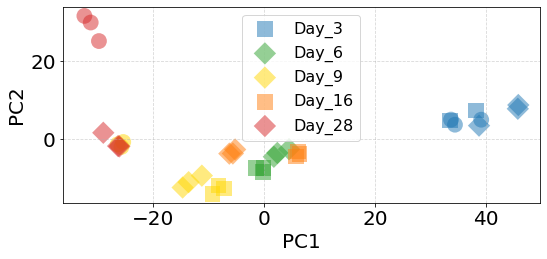

In [20]:
working_labels = ['Day_3', 'Day_6', 'Day_9', 'Day_16', 'Day_28']

for i in range(len(sampleIDs)):
    
    treatment_day = metadata[sampleIDs[i]][1]
    patient_id = metadata[sampleIDs[i]][0]
    
    # color based on treatment day
    if treatment_day == 'Day_3':
        the_color='tab:blue' 
    elif treatment_day == 'Day_6':
        the_color='tab:green'
    elif treatment_day == 'Day_9':
        the_color='gold'
    elif treatment_day == 'Day_16':
        the_color='tab:orange'
    elif treatment_day == 'Day_28':
        the_color='tab:red'
    else:
        raise ValueError('computer says no')
        
    # marker based on patient ID
    if patient_id == '6':
        the_marker = 'o'
    elif patient_id == '16':
        the_marker = 's'
    elif patient_id == '17':
        the_marker = 'D'
    else:
        raise ValueError('computer says no again')
        
    # labels
    if treatment_day in working_labels:
        the_label=treatment_day
        working_labels.remove(treatment_day)
    else:
      the_label=''
      
    matplotlib.pyplot.scatter(principalComponents[i, 0], principalComponents[i, 1], c=the_color, s=250, alpha=0.5, edgecolors='none', marker=the_marker, label=the_label)

matplotlib.pyplot.legend(fontsize=16)
matplotlib.pyplot.xlabel('PC1')
matplotlib.pyplot.ylabel('PC2')
matplotlib.pyplot.grid(alpha=0.5, ls='--')
matplotlib.pyplot.tight_layout()

matplotlib.pyplot.savefig('pca.svg')

## 2.2. RUNX2-PPARG 

In [21]:
# RUNX2 ==>  ENSG00000124813
# PPARG ==> ENSG00000132170
targets=['ENSG00000124813', 'ENSG00000132170'] 

In [22]:
sub = expression.loc[targets, ]
sub

,thBS_MSC_1,thBS_MSC_3,thBS_MSC_4,thBS_MSC_5,thBS_MSC_6,thBS_MSC_7,thBS_MSC_8,thBS_MSC_9,thBS_MSC_10,thBS_MSC_11,...,thBS_MSC_30,thBS_MSC_31,thBS_MSC_32,thBS_MSC_33,thBS_MSC_37,thBS_MSC_38,thBS_MSC_39,thBS_MSC_43,thBS_MSC_44,thBS_MSC_45
ENSG00000124813,13.297374,22.447391,16.519808,14.831718,10.686293,8.988245,10.756189,7.257497,44.557240,74.939293,...,14.180360,40.920211,40.579583,42.671255,40.334031,33.96801,47.458071,17.801390,18.680744,17.705067
ENSG00000132170,5.465651,2.825620,0.781200,1.574319,1.231893,3.725705,5.251543,4.564146,6.918534,7.137037,...,5.812747,14.329348,15.772878,3.776372,12.643850,12.46467,24.148982,18.055275,18.760832,21.395034


In [23]:
sampleIDs = sub.columns.to_list()

/Users/adrian/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/adrian/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Day_3
16
[3.73306951 4.48847584]
17
[4.04612503 3.89061379 3.41768964]
6
[3.16803952 3.42709517 2.85947216]
[4.1107726719347495, 3.784809482978975, 3.1515356165232453] mean 3.784809482978975
Day_6
16
[3.51230178 4.79970434 4.57564739]
17
[5.47758797 6.22765045 5.4897122 ]
6
[]
[4.295884504390294, 5.731650207012399] mean 5.013767355701347
Day_9
16
[4.38279771 4.18536575 4.04890806]
17
[5.70619506 5.78410948 5.60273567]
6
[4.91458357 4.96319538 4.87052756]
[4.205690506043592, 5.697680069312934, 4.916102170183014] mean 4.916102170183014
Day_16
16
[3.63055223 3.64568012 3.8258223 ]
17
[5.35474167 5.34268213 5.41519264]
6
[]
[3.700684884154302, 5.370872145898875] mean 4.535778515026588
Day_28
16
[]
17
[5.33392568 5.08610479 5.56858155]
6
[4.15391803 4.22348001 4.14609042]
[5.329537341403047, 4.174496150869003] mean 4.752016746136025
ENSG00000124813
[3.6823725904789897, 5.013767355701347, 4.93982424851318, 4.535778515026588, 4.752016746136025]
Day_3
16
[2.45039326 1.49856746]
17
[-0.35623658

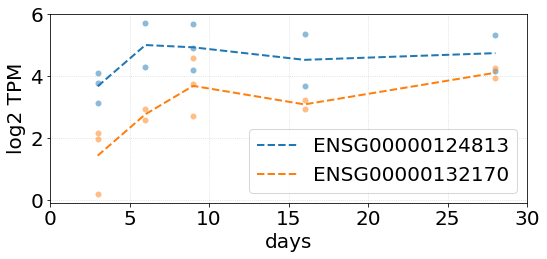

In [24]:
the_colors = ['tab:blue', 'tab:orange']
for i in range(len(sub.index)):
    working_gene = sub.index[i]
    the_color = the_colors[i]
    
    trajectory = []
    pointsy = []; pointsx = []
    for day in days:
        print(day)
        patient_expression_values = []
        for donor in donors:
            print(donor)
            # retrieve sample labels
            sample_labels = []
            for sample in sampleIDs:
                if metadata[sample] == (donor, day):
                    sample_labels.append(sample)

            # retrieve expression
            exp = numpy.log2([sub[label][working_gene] for label in sample_labels])
            print(exp)

            average_expression = numpy.mean(exp)
            if numpy.isnan(average_expression) == False:
                patient_expression_values.append(average_expression)
                pointsy.append(average_expression)
                pointsx.append(int(day.split('_')[1]))

        # compute median across patients
        median_expression = numpy.mean(patient_expression_values)
        print(patient_expression_values, 'mean', numpy.median(patient_expression_values))

        # add median value to trajectory
        trajectory.append(median_expression)        

    print(working_gene)
    print(trajectory)
    
    # plot median trajectory
    matplotlib.pyplot.plot([3, 6, 9, 16, 28], trajectory, lw=2, ls='--', label=working_gene, color=the_color)
    matplotlib.pyplot.plot(pointsx, pointsy, 'o', alpha=0.5, color=the_color, mew=0)
    
matplotlib.pyplot.legend()
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlim([0, 30])
matplotlib.pyplot.ylabel('log2 TPM')
matplotlib.pyplot.xlabel('days')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.savefig('toggle_switch.svg')

In [25]:
expression.head()

,thBS_MSC_1,thBS_MSC_3,thBS_MSC_4,thBS_MSC_5,thBS_MSC_6,thBS_MSC_7,thBS_MSC_8,thBS_MSC_9,thBS_MSC_10,thBS_MSC_11,...,thBS_MSC_30,thBS_MSC_31,thBS_MSC_32,thBS_MSC_33,thBS_MSC_37,thBS_MSC_38,thBS_MSC_39,thBS_MSC_43,thBS_MSC_44,thBS_MSC_45
ENSG00000113368,23.534866,14.741892,28.775413,26.322386,19.928841,21.907930,22.592282,21.910533,11.242831,8.818137,...,3.590999,9.057730,9.293932,9.965295,1.172933,1.385918,1.966846,0.225611,0.170226,0.366567
ENSG00000134363,2.903333,1.600485,2.092479,2.251130,2.154587,1.663260,1.762730,2.122335,11.505109,11.196570,...,6.458744,17.631372,15.639317,18.968898,83.397769,80.136323,92.952677,17.026025,15.582461,12.844514
ENSG00000174738,5.261705,3.221142,3.148359,3.039520,2.241439,4.812780,4.703140,3.243598,10.905147,10.400598,...,6.117684,6.266457,6.109248,7.830408,16.045498,13.472039,23.314625,15.257704,18.062990,16.697391
ENSG00000114120,41.313929,35.021274,29.528056,27.401058,14.363185,32.227085,29.736201,23.390325,72.250416,57.777199,...,58.369444,116.998536,104.960212,131.145229,98.553233,111.337577,171.599773,195.853221,255.727944,299.372829
ENSG00000007944,0.039006,0.399355,0.255548,0.482754,0.204503,0.625252,0.371149,0.560888,2.163186,1.873812,...,0.961869,2.737167,2.129975,2.236796,4.522522,4.317794,5.343296,1.567016,1.446328,1.448905


## 2.3. volcano plot

In [26]:
# obtain a TPM trajectory (discrete for very low) across time over replicates and patients
expression_trajectories = {}

for working_gene in working_genes:
    
    ensembl_trajectory = []
    for day in days:
        expression_across_donors = []
        for donor in donors:
            
            # retrieve sample labels
            sample_labels = []
            for sample in sampleIDs:
                if metadata[sample] == (donor, day):
                    sample_labels.append(sample)
            
            # retrieve expression
            try:
                exp = [expression[label][working_gene] for label in sample_labels]
            except:
                exp = [0 for label in sample_labels]
                print('ENSEMBL ID {} not found in expression data set. Setting expression to zero.'.format(working_gene))
                    
            average_expression = numpy.mean(exp)
            if numpy.isnan(average_expression) == False:
                expression_across_donors.append(average_expression)
                
        # compute median across patients
        median_expression = numpy.median(expression_across_donors)
        
        # round values, useful for very low values
        round_value = numpy.around(median_expression) + 1
        
        # add round value to trajectory
        ensembl_trajectory.append(round_value)
    
    # add trajectory to dictionary
    expression_trajectories[working_gene] = ensembl_trajectory

/Users/adrian/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/adrian/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [27]:
expression_trajectories

{'ENSG00000113368': [23.0, 8.0, 4.0, 7.0, 2.0],
 'ENSG00000134363': [3.0, 11.0, 21.0, 13.0, 51.0],
 'ENSG00000174738': [5.0, 11.0, 12.0, 7.0, 18.0],
 'ENSG00000114120': [29.0, 66.0, 63.0, 83.0, 190.0],
 'ENSG00000007944': [1.0, 3.0, 4.0, 3.0, 4.0],
 'ENSG00000180573': [11.0, 31.0, 61.0, 30.0, 30.0],
 'ENSG00000185291': [2.0, 3.0, 7.0, 3.0, 3.0],
 'ENSG00000139354': [5.0, 3.0, 2.0, 3.0, 2.0],
 'ENSG00000197415': [27.0, 15.0, 13.0, 15.0, 6.0],
 'ENSG00000157150': [4.0, 15.0, 20.0, 35.0, 50.0],
 'ENSG00000164112': [3.0, 7.0, 19.0, 7.0, 31.0],
 'ENSG00000029559': [1.0, 2.0, 13.0, 2.0, 11.0],
 'ENSG00000142583': [2.0, 3.0, 6.0, 2.0, 2.0],
 'ENSG00000130595': [1.0, 1.0, 4.0, 1.0, 1.0],
 'ENSG00000147852': [3.0, 3.0, 4.0, 5.0, 7.0],
 'ENSG00000115602': [1.0, 1.0, 2.0, 3.0, 64.0],
 'ENSG00000136244': [7.0, 3.0, 4.0, 3.0, 2.0],
 'ENSG00000134853': [52.0, 123.0, 147.0, 126.0, 235.0],
 'ENSG00000197299': [4.0, 2.0, 1.0, 2.0, 1.0],
 'ENSG00000165124': [8.0, 19.0, 18.0, 14.0, 32.0],
 'ENSG000001391

In [28]:
plotting_df = pandas.DataFrame(expression_trajectories).transpose()
plotting_df.columns = days
plotting_df.head()

,Day_3,Day_6,Day_9,Day_16,Day_28
ENSG00000113368,23.0,8.0,4.0,7.0,2.0
ENSG00000134363,3.0,11.0,21.0,13.0,51.0
ENSG00000174738,5.0,11.0,12.0,7.0,18.0
ENSG00000114120,29.0,66.0,63.0,83.0,190.0
ENSG00000007944,1.0,3.0,4.0,3.0,4.0


In [29]:
plotting_df['log2_average_TPM'] = numpy.log2(plotting_df[['Day_3', 'Day_6', 'Day_9', 'Day_16', 'Day_28']].mean(axis=1))
plotting_df

,Day_3,Day_6,Day_9,Day_16,Day_28,log2_average_TPM
ENSG00000113368,23.0,8.0,4.0,7.0,2.0,3.137504
ENSG00000134363,3.0,11.0,21.0,13.0,51.0,4.307429
ENSG00000174738,5.0,11.0,12.0,7.0,18.0,3.405992
ENSG00000114120,29.0,66.0,63.0,83.0,190.0,6.429616
ENSG00000007944,1.0,3.0,4.0,3.0,4.0,1.584963
...,...,...,...,...,...,...
ENSG00000105664,23.0,48.0,131.0,21.0,72.0,5.882643
ENSG00000109685,37.0,19.0,12.0,14.0,8.0,4.169925
ENSG00000170017,294.0,129.0,90.0,141.0,284.0,7.551516
ENSG00000122966,11.0,5.0,3.0,5.0,2.0,2.378512


In [30]:
plotting_df['log2FC_28_vs_3'] = numpy.log2(plotting_df['Day_28']/plotting_df['Day_3'])
plotting_df.shape

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


(1106, 7)

In [31]:
plotting_df = plotting_df[plotting_df['log2_average_TPM'] > 1]
plotting_df.shape

(1074, 7)

In [32]:
plotting_df = plotting_df[numpy.abs(plotting_df['log2FC_28_vs_3']) > 1]
plotting_df.shape

(941, 7)

In [33]:
x = plotting_df['log2FC_28_vs_3']
y = plotting_df['log2_average_TPM']
z = plotting_df['Day_28']
t = plotting_df['Day_3']

In [34]:
f = open(volcano_info_file, 'w')

In [35]:
%%time

# get TFs as orange and metabolic genes as green
ensembl_IDs = list(plotting_df.index.values)
print(len(ensembl_IDs), ensembl_IDs[:5])

the_colors = []; the_alphas = []; the_zorder = []; the_ms = []
for i in range(len(ensembl_IDs)):
    if i%10 == 0:
        print('working on {}/{}...'.format(i, len(ensembl_IDs)))
    
    label = None
    if ensembl_IDs[i] in TF_ensembl_ids:
        #print('TF detected: {} \t {}'.format(ensembl_ID, TF_map[ensembl_ID]))    
        
        if x[i] > 0:
            label = 'orange_up'
        if x[i] < 0:
            label = 'orange_down'
            
        the_colors.append('orange')
        the_alphas.append(2/3)
        the_zorder.append(1000)
        the_ms.append(12)
    elif ensembl_IDs[i] in metabolic_genes:
        
        if x[i] > 0:
            label = 'green_up'
        if x[i] < 0:
            label = 'green_down'
            
        the_colors.append('green')
        the_alphas.append(2/3)
        the_zorder.append(1000)
        the_ms.append(12)
    else:   
        
        if x[i] > 0:
            label = 'black_up'
        if x[i] < 0:
            label = 'black_down'
            
        the_colors.append('black')
        the_alphas.append(1/6)
        the_zorder.append(0)
        the_ms.append(4)
    
    # associate symbol and description to target gene
    symbol = None; info = None
    try:
        info = ensembl_rest.lookup(id=ensembl_IDs[i])['description'].split(' [Source')[0]
    except:
        info = 'Not available'
    try:
        symbol = annotation.gene_name_of_gene_id(ensembl_IDs[i])
    except:
        symbol = 'Not available'
    f.write('{} \t {} \t {} \t {} \t {} \t {} \t {} \t {}\n'.format(label, ensembl_IDs[i], symbol, info, x[i], y[i], int(z[i]-1), int(t[i]-1)))

941 ['ENSG00000113368', 'ENSG00000134363', 'ENSG00000174738', 'ENSG00000114120', 'ENSG00000007944']
working on 0/941...
working on 10/941...
working on 20/941...
working on 30/941...
working on 40/941...
working on 50/941...
working on 60/941...
working on 70/941...
working on 80/941...
working on 90/941...
working on 100/941...
working on 110/941...
working on 120/941...
working on 130/941...
working on 140/941...
working on 150/941...
working on 160/941...
working on 170/941...
working on 180/941...
working on 190/941...
working on 200/941...
working on 210/941...
working on 220/941...
working on 230/941...
working on 240/941...
working on 250/941...
working on 260/941...
working on 270/941...
working on 280/941...
working on 290/941...
working on 300/941...
working on 310/941...
working on 320/941...
working on 330/941...
working on 340/941...
working on 350/941...
working on 360/941...
working on 370/941...
working on 380/941...
working on 390/941...
working on 400/941...
working o

In [36]:
f.close()

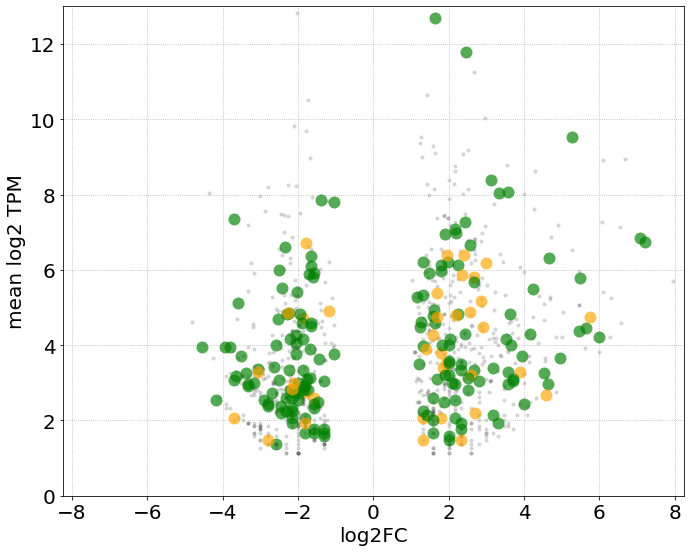

<Figure size 576x288 with 0 Axes>

In [37]:
matplotlib.pyplot.figure(figsize=(10, 10))

for i in range(len(x)):
    matplotlib.pyplot.plot(x[i], y[i], 'o', color=the_colors[i], alpha=the_alphas[i], mew=0, ms=the_ms[i], zorder=the_zorder[i])

matplotlib.pyplot.grid(0.5, ls=':')
matplotlib.pyplot.xlim([-8.25, 8.25])
matplotlib.pyplot.ylim([0, 13])
matplotlib.pyplot.xlabel('log2FC')
matplotlib.pyplot.ylabel('mean log2 TPM')
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()
matplotlib.pyplot.savefig('volcano.svg')
matplotlib.pyplot.clf()